# True Parameters (0.2, 3)

## Variance

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\4276543014.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


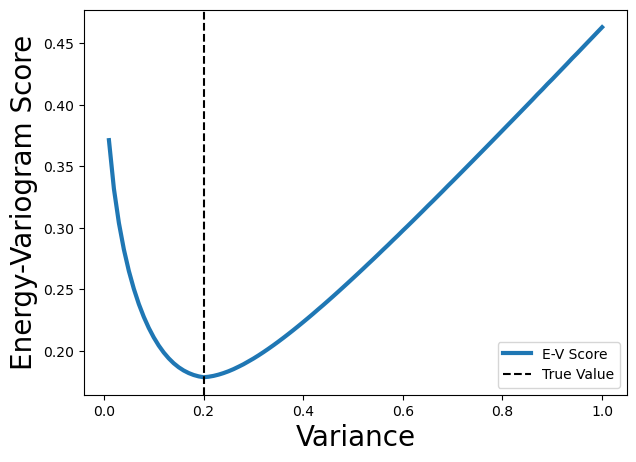

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm
import torch.nn as nn

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel
length_scale = 3
variance = 0.2
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

#generate observations (real samples)
torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


#Choose SR_beta value
SR_beta = 1.0

SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.01, 1, 100)):
    torch.manual_seed(42) 
    cov_ = RBF(i, length_scale)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.01, 1, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=0.2, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()



## Length Scale

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\408127478.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


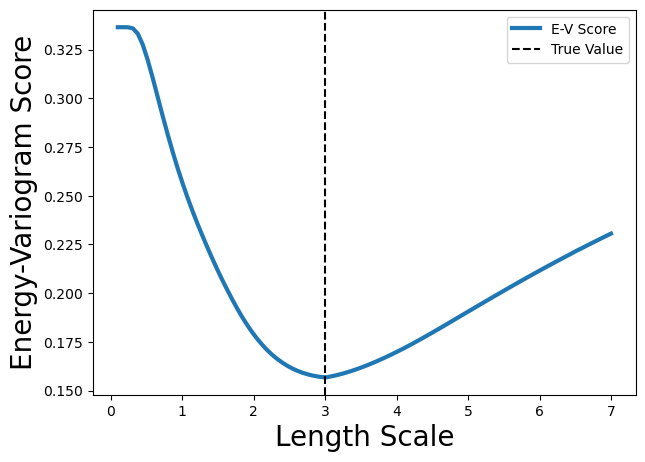

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon #to avoid division by 0

# Define the RBF kernel
length_scale = 3
variance = 0.2
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

SR_beta = 1.0
# Variogram
SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.1, 7, 100)):
    torch.manual_seed(42)  
    cov_ = RBF(variance, i)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.1, 7, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=3, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()


    

## Bivariate Contour Plot

C:\Users\rikhi\AppData\Local\Temp\ipykernel_16024\1790028029.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)


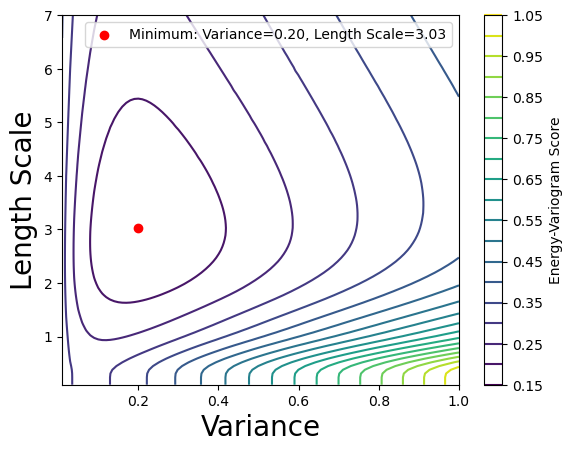

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm


def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  # Assuming SR_eval_V is a function
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  # Assuming SR_eval_E is a function
    return a * SR_eval_V_result + SR_eval_E_result

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel

epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate pairwise distances using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel using the RBF function
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

true_length_scale = 3
true_variance = 0.2
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


SR_EVgp = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        SR_EVgp[i, j] = SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1)

plt.contour(variances, length_scales, SR_EVgp, levels=20)
plt.colorbar(label='Energy-Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_EVgp.min()
min_indices = np.unravel_index(torch.argmin(SR_EVgp).item(), SR_EVgp.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()


# True Parameters (0.1, 2)

## Variance

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\651075754.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


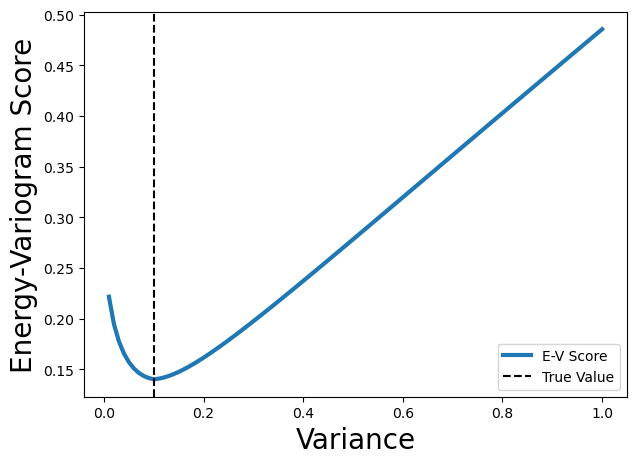

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm
import torch.nn as nn

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 


def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel
length_scale = 2
variance = 0.1
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

#generate observations (real samples)
torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


#Choose SR_beta value
SR_beta = 1.0

SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.01, 1, 100)):
    torch.manual_seed(42) 
    cov_ = RBF(i, length_scale)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.01, 1, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=0.1, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()



## Length Scale

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\3156831031.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


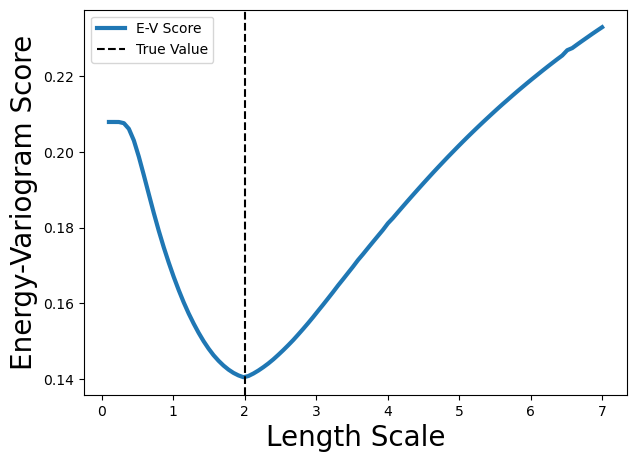

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon #to avoid division by 0

# Define the RBF kernel
length_scale = 2
variance = 0.1
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

SR_beta = 1.0
# Variogram
SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.1, 7, 100)):
    torch.manual_seed(42)  
    cov_ = RBF(variance, i)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.1, 7, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=2, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()


    

## Bivariate Contour Plot

C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\1746452990.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)


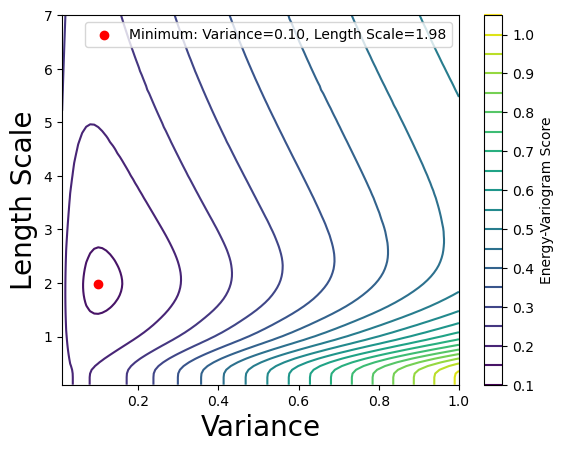

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm


def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  # Assuming SR_eval_V is a function
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  # Assuming SR_eval_E is a function
    return a * SR_eval_V_result + SR_eval_E_result

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel

epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate pairwise distances using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel using the RBF function
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

true_length_scale = 2
true_variance = 0.1
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


SR_EVgp = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        SR_EVgp[i, j] = SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1)

plt.contour(variances, length_scales, SR_EVgp, levels=20)
plt.colorbar(label='Energy-Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_EVgp.min()
min_indices = np.unravel_index(torch.argmin(SR_EVgp).item(), SR_EVgp.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()


# True Parameters (0.6, 5)

## Variance

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\2412576762.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


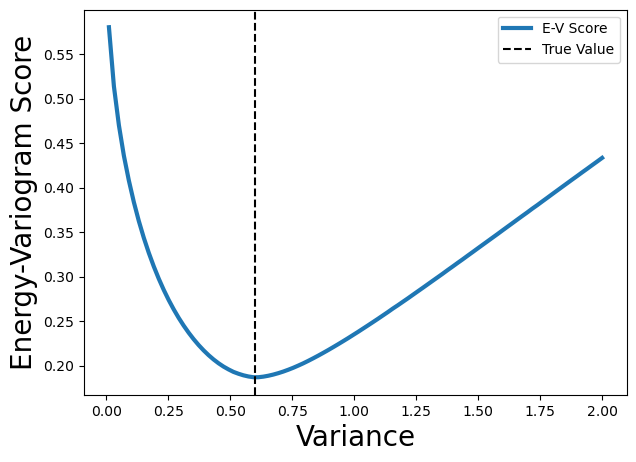

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm
import torch.nn as nn

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel
length_scale = 5
variance = 0.6
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

#generate observations (real samples)
torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


#Choose SR_beta value
SR_beta = 1.0

SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.01, 2, 100)):
    torch.manual_seed(42) 
    cov_ = RBF(i, length_scale)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.01, 2, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=0.6, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()



## Length Scale

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\1061445409.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


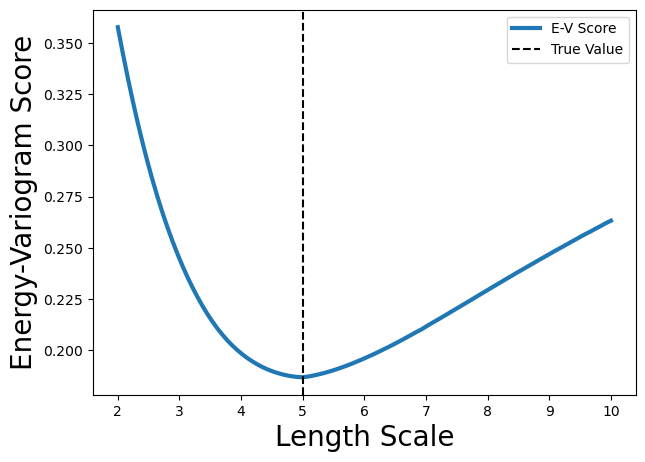

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon #to avoid division by 0

# Define the RBF kernel
length_scale = 5
variance = 0.6
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

SR_beta = 1.0
# Variogram
SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(2, 10, 100)):
    torch.manual_seed(42)  
    cov_ = RBF(variance, i)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(2, 10, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=5, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()

## Bivariate Contour Plot

C:\Users\rikhi\AppData\Local\Temp\ipykernel_16024\2902084982.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)


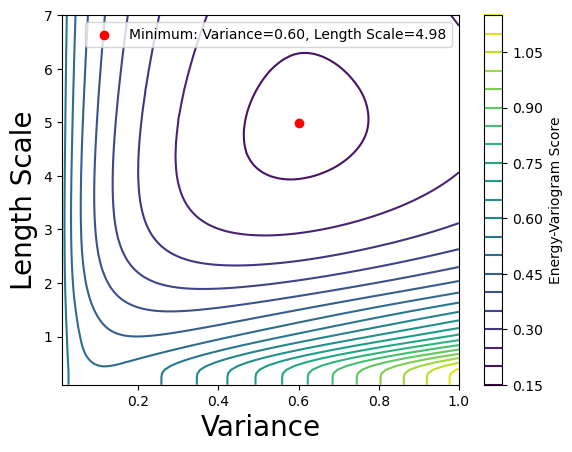

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm


def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 20000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  # Assuming SR_eval_V is a function
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  # Assuming SR_eval_E is a function
    return a * SR_eval_V_result + SR_eval_E_result

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel

epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate pairwise distances using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel using the RBF function
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

true_length_scale = 5
true_variance = 0.6
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


SR_EVgp = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        SR_EVgp[i, j] = SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1)

plt.contour(variances, length_scales, SR_EVgp, levels=20)
plt.colorbar(label='Energy-Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_EVgp.min()
min_indices = np.unravel_index(torch.argmin(SR_EVgp).item(), SR_EVgp.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()


# Weighting 1e-4

## Variance

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\3085301979.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


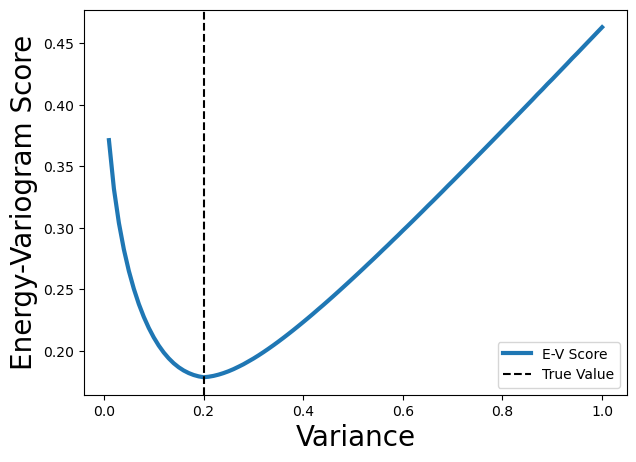

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm
import torch.nn as nn

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 10000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel
length_scale = 3
variance = 0.2
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

#generate observations (real samples)
torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


#Choose SR_beta value
SR_beta = 1.0

SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.01, 1, 100)):
    torch.manual_seed(42) 
    cov_ = RBF(i, length_scale)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.01, 1, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=0.2, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()



## Length Scale 

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\4095698506.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


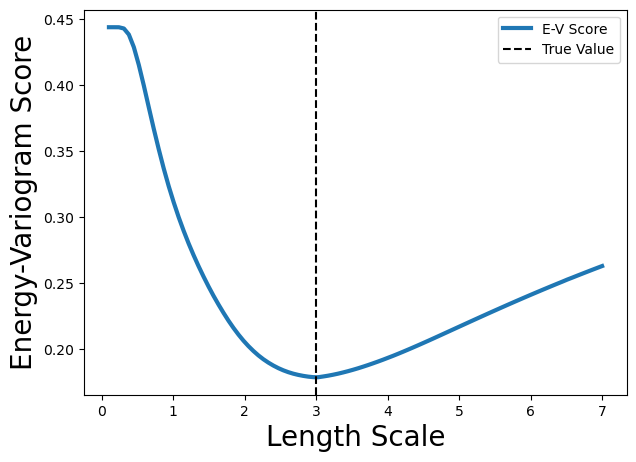

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 10000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon #to avoid division by 0

# Define the RBF kernel
length_scale = 3
variance = 0.2
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

SR_beta = 1.0
# Variogram
SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.1, 7, 100)):
    torch.manual_seed(42)  
    cov_ = RBF(variance, i)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.1, 7, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=3, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()


    

## Bivariate Contour Plot

C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\1238516446.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)


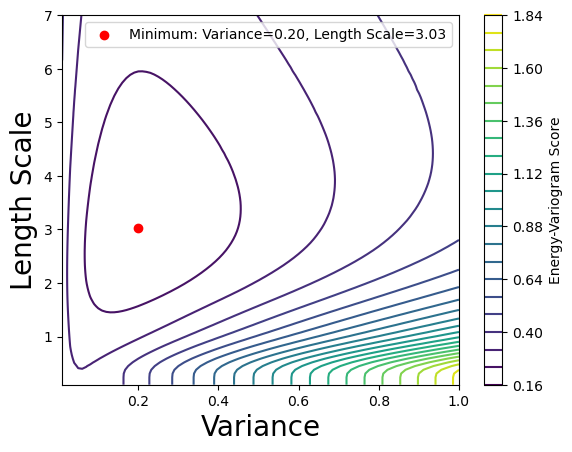

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm


def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 


def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 10000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  # Assuming SR_eval_V is a function
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  # Assuming SR_eval_E is a function
    return a * SR_eval_V_result + SR_eval_E_result

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel

epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate pairwise distances using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel using the RBF function
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

true_length_scale = 3
true_variance = 0.2
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


SR_EVgp = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        SR_EVgp[i, j] = SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1)

plt.contour(variances, length_scales, SR_EVgp, levels=20)
plt.colorbar(label='Energy-Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_EVgp.min()
min_indices = np.unravel_index(torch.argmin(SR_EVgp).item(), SR_EVgp.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()


# Weighting 6.67e-5

## Variance

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\3045876804.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


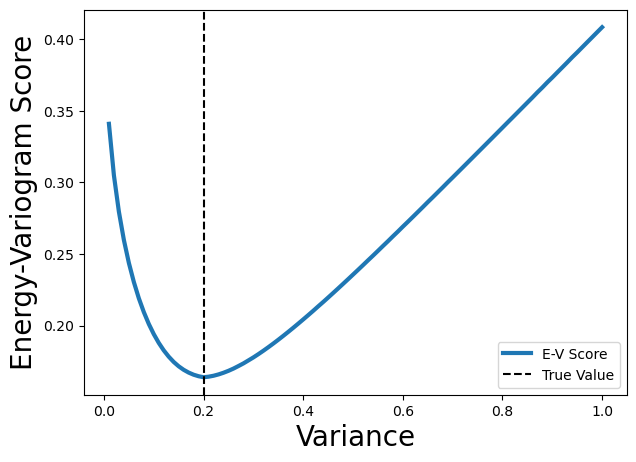

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm
import torch.nn as nn

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 15000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel
length_scale = 3
variance = 0.2
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

#generate observations (real samples)
torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


#Choose SR_beta value
SR_beta = 1.0

SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.01, 1, 100)):
    torch.manual_seed(42) 
    cov_ = RBF(i, length_scale)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.01, 1, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=0.2, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()



## Length Scale

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rikhi\AppData\Local\Temp\ipykernel_19440\1223887233.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


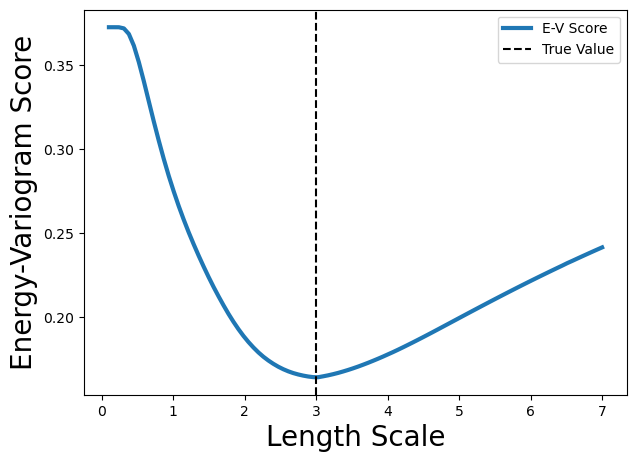

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 



def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 15000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  
    return a * SR_eval_V_result + SR_eval_E_result


def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel


epsilon = 1e-9  
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate distance matrix using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon #to avoid division by 0

# Define the RBF kernel
length_scale = 3
variance = 0.2
rbf_kernel = RBF(variance, length_scale)

# Compute the true covariance matrix
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(25), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))

SR_beta = 1.0
# Variogram
SR_EV = []
mean = torch.zeros(25)
for i in tqdm(torch.linspace(0.1, 7, 100)):
    torch.manual_seed(42)  
    cov_ = RBF(variance, i)(locs, locs)
    multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
    sims = multi.sample((100,))
    SR_EV.append(SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1))

plt.figure(figsize=(7, 5))
plt.plot(torch.linspace(0.1, 7, 100), SR_EV , label='E-V Score', linewidth=3)
plt.axvline(x=3, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale', fontsize=20)
plt.ylabel('Energy-Variogram Score', fontsize=20)


plt.show()


    

## Bivariate Contour Plot

C:\Users\rikhi\AppData\Local\Temp\ipykernel_16024\1190172440.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)


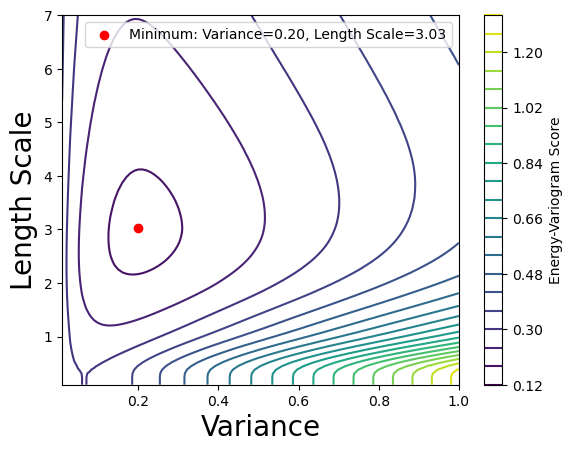

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm import tqdm


def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval_E(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples)) 


def variogram(obs, sims, dist_mat, p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.

    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    n = obs.size(0)
    m = sims.size(0)
    w_ij = torch.nan_to_num(1 / dist_mat, nan=0, posinf=0, neginf=0)
    diff_y_y = torch.abs(obs.unsqueeze(1) - obs) ** p
    diff_Y_Y = torch.abs(sims.unsqueeze(2) - sims.unsqueeze(1)).pow(p).mean(dim=0)

    SR = w_ij * (diff_y_y - diff_Y_Y) ** 2
    return SR.sum().item()


def SR_eval_V(real_samples, fake_samples, distance_matrix, p):
    vario_ = 0
    for k in range(len(real_samples)):
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        vario_ = torch.tensor(vario_) + variogram(real_samples[k], fake_samples, dist_mat, 1)
    return vario_

def SR_eval_EV(real_samples, fake_samples, Beta, distance_matrix, p):
    a = 1 / 15000
    SR_eval_V_result = SR_eval_V(real_samples, fake_samples, distance_matrix, p)  # Assuming SR_eval_V is a function
    SR_eval_E_result = SR_eval_E(Beta, real_samples, fake_samples)  # Assuming SR_eval_E is a function
    return a * SR_eval_V_result + SR_eval_E_result

def pairwise_distance(x1, x2):
    return ((x1.unsqueeze(1) - x2.unsqueeze(0)) ** 2).sum(-1)

def RBF(variance, length_scale):
    def rbf_kernel(x1, x2):
        dist = pairwise_distance(x1, x2)
        covariance_matrix = variance*torch.exp(-0.5 * dist / length_scale ** 2)
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(covariance_matrix.shape[0]) * (-min_eig + 1e-6)
        
        return covariance_matrix
    return rbf_kernel

epsilon = 1e-9  # Small epsilon value to avoid division by zero
locs = torch.meshgrid(torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4]))
locs = torch.stack((locs[0].flatten(), locs[1].flatten())).t().float()

# Calculate pairwise distances using the pairwise_distance function
dist_mat = pairwise_distance(locs, locs)
dist_mat += epsilon

# Define the RBF kernel using the RBF function
length_scales = torch.linspace(0.1, 7, 100)
variances = torch.linspace(0.01, 1, 100)

true_length_scale = 3
true_variance = 0.2
rbf_kernel = RBF(true_variance, true_length_scale)
true_cov = rbf_kernel(locs, locs)

torch.manual_seed(42)
mvn = MultivariateNormal(torch.zeros(locs.size(0)), covariance_matrix=true_cov.float())
obs_z = mvn.sample((100,))


SR_EVgp = torch.zeros((len(length_scales), len(variances)))

for i, length_scale in enumerate(length_scales):
    for j, variance in enumerate(variances):
        vario_ = 0
        cov_ = RBF(variance, length_scale)(locs, locs)
        torch.manual_seed(42)
        multi = MultivariateNormal(torch.zeros(25), covariance_matrix=cov_.float())
        sims = multi.sample((100,))
        SR_EVgp[i, j] = SR_eval_EV(obs_z, sims, SR_beta, dist_mat, 1)

plt.contour(variances, length_scales, SR_EVgp, levels=20)
plt.colorbar(label='Energy-Variogram Score')
plt.title("")
plt.xlabel('Variance', fontsize=20)
plt.ylabel('Length Scale', fontsize=20)
# Highlight minimum value
min_value = SR_EVgp.min()
min_indices = np.unravel_index(torch.argmin(SR_EVgp).item(), SR_EVgp.shape)
min_var, min_ls = variances[min_indices[1]].item(), length_scales[min_indices[0]].item()
plt.scatter(min_var, min_ls, color='red', label=f'Minimum: Variance={min_var:.2f}, Length Scale={min_ls:.2f}')
plt.legend()

plt.show()
